Processing all data files...
Data aggregation complete.

Applying SMOTE to the training data...
SMOTE complete.

Starting Hyperparameter Tuning (GridSearchCV)...
This may take a long time depending on your hardware.
Fitting 3 folds for each of 24 candidates, totalling 72 fits
GridSearchCV complete.

Best parameters found: 
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Best F1-score during cross-validation: 
0.9640716682640845

Evaluating the best model on the test set...

Final Classification Report on Test Set:
              precision    recall  f1-score   support

    Walk (1)       0.98      0.95      0.96      3218
     FoG (2)       0.63      0.85      0.72       344

    accuracy                           0.94      3562
   macro avg       0.81      0.90      0.84      3562
weighted avg       0.95      0.94      0.94      3562

Final Confusion Matrix:


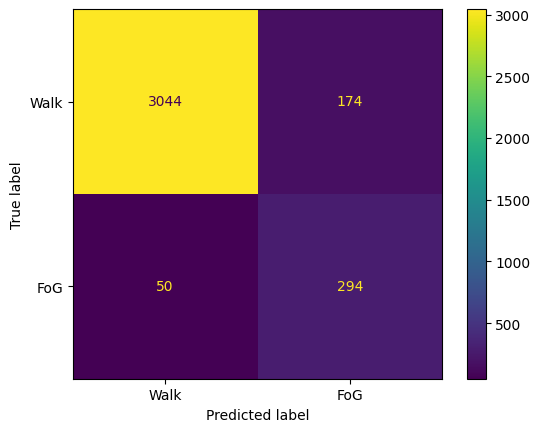

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom processing function
import sys
sys.path.append('../')
from src.data_processing import process_file_to_features

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

# --- 1. DATA AGGREGATION & PREPARATION (Same as before) ---
raw_data_path = '../data/raw/'
all_files = [f for f in os.listdir(raw_data_path) if f.endswith('.txt')]
list_of_dfs = []

print("Processing all data files...")
for file in all_files:
    file_path = os.path.join(raw_data_path, file)
    processed_df = process_file_to_features(file_path)
    list_of_dfs.append(processed_df)

master_df = pd.concat(list_of_dfs, ignore_index=True)
print("Data aggregation complete.")

X = master_df.drop('Label', axis=1)
y = master_df['Label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("SMOTE complete.")


# --- 2. HYPERPARAMETER TUNING SETUP ---
# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],         # Number of trees in the forest
    'max_depth': [10, 20, None],        # Maximum depth of the tree
    'min_samples_split': [2, 5],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2]          # Minimum samples required at a leaf node
}

# Instantiate the model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Instantiate the GridSearchCV object
# cv=3 means 3-fold cross-validation
# scoring='f1_macro' optimizes for the F1-score, balancing precision and recall
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_macro')


# --- 3. RUN THE GRID SEARCH ---
print("\nStarting Hyperparameter Tuning (GridSearchCV)...")
print("This may take a long time depending on your hardware.")
# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)
print("GridSearchCV complete.")


# --- 4. SHOW BEST RESULTS ---
print("\nBest parameters found: ")
print(grid_search.best_params_)

print("\nBest F1-score during cross-validation: ")
print(grid_search.best_score_)


# --- 5. FINAL EVALUATION ---
print("\nEvaluating the best model on the test set...")
# The best model is already trained and stored in grid_search.best_estimator_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print the final classification report
print("\nFinal Classification Report on Test Set:")
print(classification_report(y_test, y_pred, target_names=['Walk (1)', 'FoG (2)']))

# Display the final confusion matrix
print("Final Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Walk', 'FoG'])
disp.plot()
plt.show()